In [1]:
# Imports
import numpy as np
import tqdm
from scipy.integrate import dblquad
from scipy.interpolate import interp1d
from astropy.cosmology import Planck18 as cosmo
from scipy.interpolate import NearestNDInterpolator as NearND
import pandas as pd
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.utils.data import download_file

### The eRASS1 catalogue (erass1cl_main_v3.2)

(from the catalogue description)
The primary catalog of 12,247 optically confirmed galaxy groups and clusters detected in the 0.2-2.3 keV as extended X-ray sources in a 13116 square degree region in the western Galactic hemisphere of the sky, which eROSITA surveyed in its first six months of operation. The clusters in the sample span the redshift range from 0.003 to 1.32. See Bulbul et al. (2024) for further details.

In [2]:
erass1clusters = pd.read_csv('data/eROSITA/erass1cl_primary_v3.2.csv', sep=",", header=0)
print(erass1clusters.columns)

Index(['DETUID', 'NAME', 'RA', 'DEC', 'EXT_LIKE', 'DET_LIKE_0', 'EXP',
       'BEST_Z', 'BEST_ZERR', 'CR500', 'CR500_L', 'CR500_H', 'CTS500',
       'CTS500_L', 'CTS500_H', 'F300kpc', 'F300kpc_L', 'F300kpc_H', 'F500',
       'F500_L', 'F500_H', 'L500', 'L500_L', 'L500_H', 'KT', 'KT_L', 'KT_H',
       'MGAS500', 'MGAS500_L', 'MGAS500_H', 'YX500', 'YX500_L', 'YX500_H',
       'M500', 'M500_L', 'M500_H', 'FGAS500', 'FGAS500_L', 'FGAS500_H', 'R500',
       'R500_L', 'R500_H'],
      dtype='object')


In [3]:
L500 = erass1clusters["L500"]
z = erass1clusters["BEST_Z"]

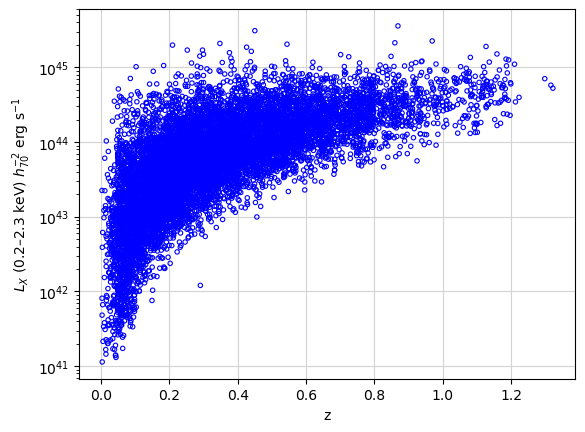

In [4]:
plt.scatter(z, L500*1e42, facecolors = 'none', edgecolors = 'blue', s = 10, linewidth = 0.8, zorder = 3)
plt.yscale("log")
plt.xlabel("z")
plt.ylabel(r"$L_X\ (0.2$–$2.3\ \mathrm{keV})\ h_{70}^{-2}\ \mathrm{erg\ s}^{-1}$")
plt.grid(True, color = 'lightgrey', zorder = 0)
# plt.xlim(0, 1.1)
# plt.ylim(1e41, 1e46)
plt.savefig("figures/eROSITA/L500-z.png")
plt.show()

## Selection Function

$V_{\text{max}}$ denotes the maximum co-moving volume, given by 

$$V_{\text{max}} = \int_{z_{\text{min}}}^{z_{\text{max}}}\Omega(f_{\text{X}},r_{\theta})\frac{\mathrm{d}V(z)}{\mathrm{d}z}\mathrm{d}z$$

where $\Omega(f_{\text{X}},r_{\theta})$ is the sky coverage as a function of flux $f_{\text{X}}(L_{\text{X}},z)$ and angular extent $r_{\theta}(r_c,z)$ (here $r_c$ is the core radius of the cluster surface brightness distribution, conventionally parameterised with a $\beta$-model), and $\mathrm{d}V(z)/\mathrm{d}z$ is the differential, co-moving volume, which is strongly sensitive to the cosmological framework. The maximum co-moving volume is calculated for all $N$ galaxy clusters.

## Sky coverage, $\Omega(f_{\text{X}},r_{\theta})$

For the coverage points, ChatGPT was used only to extrapolate the $x$ and $y$ values from Fig 8 in $\textit{The SRG/eROSITA All-Sky Survey}$, hereafter referred to as Clerc et al. (2024). This produced a .csv file of values 0 $< y <$ 1 which I later edited to be 0 $\leq y \leq$ 1. See selection-function.ipynb for full method.

In [5]:
# Import the .csv of points
extracted = pd.read_csv('data/extracted_selectionfunc2.csv')
extracted.columns

Index(['log10_Lx_erg_s^-1', 'p_I_given_Lx'], dtype='object')

In [6]:
# Force values x < 42.5 to be y = 0.0, and values x > 45 to be y = 1.0
indecis_less_42_5 = np.where(extracted['log10_Lx_erg_s^-1'] <= 42.7)
indecis_more_45 = np.where(extracted['log10_Lx_erg_s^-1'] >= 45)
extracted['p_I_given_Lx'][indecis_less_42_5] = 0.0
extracted['p_I_given_Lx'][indecis_more_45] = 1.0
extracted['p_I_given_Lx']

C:\Users\LilyO\AppData\Local\Temp\ipykernel_16140\4230130784.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  extracted['p_I_given_Lx'][indecis_less_42_5] = 0.0
C:\Users\LilyO\AppData\Local\Temp\ipykernel_16140\4230130784.py:5: FutureWarn

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1538    1.0
1539    1.0
1540    1.0
1541    1.0
1542    1.0
Name: p_I_given_Lx, Length: 1543, dtype: float64

Text(0, 0.5, '$p(I|L_x)$')

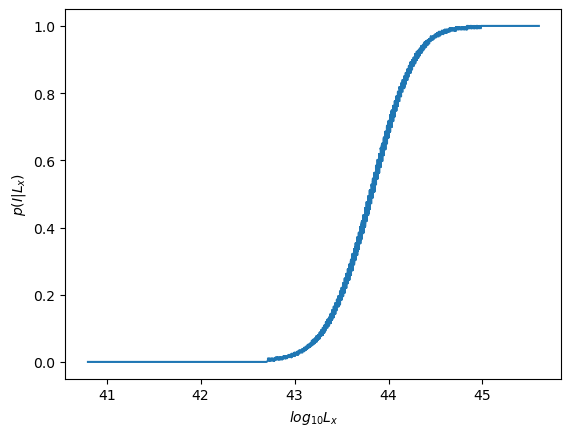

In [7]:
# Plot coverage and check (simply, by eye) it looks like Clerc et al. (2024) 
plt.plot(extracted['log10_Lx_erg_s^-1'], extracted['p_I_given_Lx'])
plt.xlabel(r'$log_{10}L_x$')
plt.ylabel(r'$p(I|L_x)$')

In [8]:
# Prepare luminosities to be converted to fluxes
log_Lums = extracted['log10_Lx_erg_s^-1']
Lums = 10**log_Lums
Lums

0       6.309573e+40
1       6.309573e+40
2       6.309573e+40
3       6.556418e+40
4       6.556418e+40
            ...     
1538    3.831187e+45
1539    3.831187e+45
1540    3.981072e+45
1541    3.981072e+45
1542    3.981072e+45
Name: log10_Lx_erg_s^-1, Length: 1543, dtype: float64

In [9]:
# Convert distance at z = 0.3 (the maximum redshift we are considering) to cm using astropy
dist = cosmo.luminosity_distance(0.3).to(u.cm).value

In [10]:
# Calculate fluxes of luminosities at a redshift of 0.3
flux_z0p3 = Lums/ (4 * np.pi * dist**2)
flux_z0p3

0       2.053444e-16
1       2.053444e-16
2       2.053444e-16
3       2.133779e-16
4       2.133779e-16
            ...     
1538    1.246856e-11
1539    1.246856e-11
1540    1.295636e-11
1541    1.295636e-11
1542    1.295636e-11
Name: log10_Lx_erg_s^-1, Length: 1543, dtype: float64

Text(0, 0.5, 'Probability of inclusion')

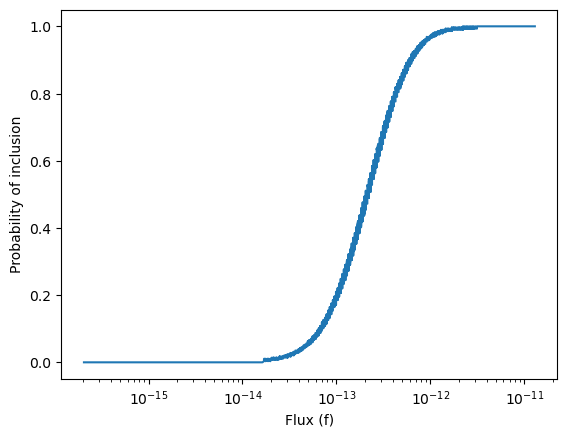

In [11]:
# Plot fluxes agsinst the probability of inclusion
# This shows at z = 0.3, the minimum flux we could detect 
plt.plot(flux_z0p3, extracted['p_I_given_Lx'])
plt.xscale('log')
plt.xlabel("Flux (f)")
plt.ylabel("Probability of inclusion")

In [12]:
# The uncertainties on L500 (1 sigma lower and upper limits)
# Here for completion but overall not included in the calculation of phi later
L500_L = erass1clusters['L500_L']
L500_H =  erass1clusters['L500_H']

In [13]:
# Check to see if the units 10^42 are already included (they're not)
L500

0        140.172
1         24.747
2          2.862
3         57.877
4          3.996
          ...   
12242     97.721
12243     15.028
12244     22.350
12245    165.113
12246     52.418
Name: L500, Length: 12247, dtype: float64

In [14]:
# Checking the previous editing has carried through
coverage = extracted['p_I_given_Lx']
coverage

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1538    1.0
1539    1.0
1540    1.0
1541    1.0
1542    1.0
Name: p_I_given_Lx, Length: 1543, dtype: float64

In [15]:
# Total sky coverage of the catalogue is 13116 square degrees, convert to steradians
tot_cov = (13116*u.deg**2).to(u.sr)
print("Total sky coverage in sr:", tot_cov)

Total sky coverage in sr: 3.9953620779224694 sr


## Differential, co-moving volume, $\frac{\mathrm{d}V(z)}{\mathrm{d}z}$

In [16]:
# Create array of redshifts within our range 
#(upper limit extended slightly to actually include the values at our redshift limit)
z_fullrange = np.arange(0.02, 0.33, 0.01) 

In [17]:
# Calculating the differential, comoving volume at each redshift point
co_mo_vol_range = cosmo.differential_comoving_volume(z_fullrange).value

In [18]:
# Interpolating differential, comoving volume
co_mo_vol_range_interp = interp1d(z_fullrange, co_mo_vol_range)

## Page-Carrera method for $\phi(L_{\text{X}_j},z)$

Page & Carrera (2000) provide an estimate of $\phi$, which expression is obtained by integrating the XLF definition and noting that $\phi$ changes little compared to the survey volume element in the volume-luminosity plane, such that it can be taken out of the integral, giving:

$$\phi(L_{\text{X}_j},z) = \frac{N_j}{\int_{L_{\text{X,min}}}^{L_{\text{X,max}}}\int_{z_{\text{min}}}^{z_{\text{max}}}\Omega(f_{\text{X}},r_{\theta})\frac{\mathrm{d}V(z)}{\mathrm{d}z}\mathrm{d}z\mathrm{d}L_{\text{X}}}$$

where $L_{\text{X}_j}$ is the bin centre and $N_j$ is the number of clusters in the $j$-th bin.

In [19]:
# Calculating the distance (cm) at each redshift in range 
DL_cm_range = cosmo.luminosity_distance(z_fullrange).to(u.cm).value

In [20]:
# Interpolate distance range
DL_cm_range_interp = interp1d(z_fullrange, DL_cm_range)

In [21]:
# Interpolating coverage range (in terms of flux)
coverage_interp1d = interp1d(flux_z0p3, coverage, bounds_error = False, fill_value = ([0], [1]))

In [22]:
# Filtering the values from the catalogue being used, first to be within redshift range, second to ignore luminosities stated as -1.0
erass1clusters_1stfilter = erass1clusters[erass1clusters["BEST_Z"] <= 0.3]
erass1clusters_z0p02 = erass1clusters_1stfilter[erass1clusters_1stfilter["BEST_Z"] >= 0.02]

erass1clusters_2ndfilter = erass1clusters_z0p02[erass1clusters_z0p02['L500'] > 0.0]

In [23]:
z_mask = erass1clusters_2ndfilter["BEST_Z"]
L500_mask = erass1clusters_2ndfilter["L500"]
len(L500_mask)

5260

In [24]:
# HACK: Use caching to avoid recomputing similar values
# Set number of points for caching z and Lx 
cache_z_grid_points = 100  
cache_L500_grid_points = 1000  

# Cache interpolator results for z and Lx
# Create meshgrid for Lx and z for caching
cache_z = np.linspace(0.02, 0.31, cache_z_grid_points)
cache_L500 = np.logspace(np.log10(L500_mask.min()), np.log10(L500_mask.max()), cache_L500_grid_points)
cache_L500_grid, cache_z_grid = np.meshgrid(cache_L500, cache_z)
cache_DL_cm = DL_cm_range_interp(cache_z)
cache_co_mo_vol = co_mo_vol_range_interp(cache_z)

In [25]:
# Create a reasonable number of bins given the large number of clusters being analysed
num_bins = 30
bin_edges = np.logspace(np.log10(L500_mask.min()*0.9), np.log10(L500_mask.max()*1.1), num_bins + 1)*1e42

In [26]:
def get_DL_cm_cached(z):
    j = np.abs(cache_z - z).argmin()
    return cache_DL_cm[j]
def get_co_mo_vol_cached(z):
    j = np.abs(cache_z - z).argmin()
    return cache_co_mo_vol[j]

# HACK: Increase integration tolerances for dblquad, check impact
integration_opts = dict(epsabs=1e-2, epsrel=1e-2) 

In [27]:
# eRASS1 catalogue has L500 in units of 1e42
Luminosity = L500*1e42

In [30]:
# Use Page-Carrera method to calculate the XLF
pc_phis = []
pc_errs = []
pc_deltas = []
for i, lower_bin_edge in enumerate(tqdm.tqdm(bin_edges[:-1])):
    upper_bin_edge = bin_edges[i+1]
    indecis_in_bin = np.where((lower_bin_edge <= Luminosity) & (Luminosity < upper_bin_edge))[0]
    clust_in_bin = len(indecis_in_bin)
    delta_L = upper_bin_edge - lower_bin_edge
    pc_deltas.append(delta_L)
    def pc_integrand_fast(z, Luminosity):
        """
        Fast integrand using cached interpolator results.
        """
        co_mo_vol_step = get_co_mo_vol_cached(z)
        # print(co_mo_vol_step)
        DL_cm_step = get_DL_cm_cached(z)
        flux = (Luminosity / (4 * np.pi * DL_cm_step**2))
        flim = 0
        if flux >= flim:
            coverage_interp = coverage_interp1d(flux)
        else:
            coverage_interp = 0
        
        survey_area = ((coverage_interp)*tot_cov).value
        # print(survey_area)
        # print(survey_area * co_mo_vol_step)
        return (survey_area * co_mo_vol_step)

    
    pc_denoms, pc_denoms_err = dblquad(pc_integrand_fast, lower_bin_edge, upper_bin_edge, 0.02, 0.3, **integration_opts)
    pc_phi = np.array(clust_in_bin) / np.array(pc_denoms)
    pc_poisson_err = pc_phi / np.sqrt(len(indecis_in_bin))
    
    pc_phis.append(pc_phi)
    pc_errs.append(pc_poisson_err)
    

  3%|▎         | 1/30 [01:05<31:45, 65.70s/it]C:\Users\LilyO\OneDrive - University of Bristol\Documents\Lily\coding\envs\eRASS_XLF\Lib\site-packages\scipy\integrate\_quadpack_py.py:1264: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
100%|██████████| 30/30 [09:53<00:00, 19.77s/it]


In [31]:
# Save file to avoid having to rerun
np.savetxt("data/eROSITA/eROSITA_phis.csv", pc_phis)

In [32]:
# Including the L500 = -1.0 values by making them equal their upper limit instead
L500_singlemask = erass1clusters_z0p02["L500"]
L500_upper = np.array(erass1clusters_z0p02["L500_H"])
L500_limits = np.where(L500_singlemask == -1.0)
L500_updatedmask = np.array(L500_singlemask)
L500_updatedmask[L500_limits] = L500_upper[L500_limits]
L500_updatedmask *= 1e42
L500_mask_42 = L500_mask * 1e42
print(len(L500_singlemask))
print(len(L500_updatedmask))
print(len(Luminosity))
print(len(L500_mask))

5943
5943
12247
5260


In [33]:
# Instead of rerunning entire Page-Carrera method, include the new L500 points by creating a ratio of the new/old observed number of clusters in bin and multiply the old phi values by it
pc_phis_mask, pc_phis_replace = [], []
old_phi_vals = np.array(pc_phis)
for i, lower_bin_edge in enumerate(tqdm.tqdm(bin_edges[:-1])):
    upper_bin_edge = bin_edges[i+1]
    
    fullz_indecis_in_bin = np.where((lower_bin_edge <= Luminosity) & (Luminosity < upper_bin_edge))[0]    
    mask_indecis_in_bin = np.where((lower_bin_edge <= L500_mask_42) & (L500_mask_42 < upper_bin_edge))[0]
    replace_indecis_in_bin = np.where((lower_bin_edge <= L500_updatedmask) & (L500_updatedmask < upper_bin_edge))[0]
   
    ratio_mask_clust_in_bin = len(mask_indecis_in_bin) / len(fullz_indecis_in_bin)
    ratio_replace_clust_in_bin = len(replace_indecis_in_bin) / len(fullz_indecis_in_bin)
    print(ratio_mask_clust_in_bin)
    old_phi = old_phi_vals[i]
    pc_phis_mask.append(old_phi * ratio_mask_clust_in_bin)
    pc_phis_replace.append(old_phi * ratio_replace_clust_in_bin)

100%|██████████| 30/30 [00:00<00:00, 849.40it/s]

0.75
0.6363636363636364
0.9
0.9310344827586207
0.9772727272727273
0.9
0.9803921568627451
0.9836065573770492
0.9901960784313726
0.9904761904761905
0.9805194805194806
0.9802955665024631
0.993103448275862
0.9616519174041298
0.9203539823008849
0.8902877697841727
0.7842261904761905
0.6782608695652174
0.5630965005302226
0.4259818731117825
0.32855778414517667
0.232
0.1807909604519774
0.11641791044776119
0.12683823529411764
0.10071942446043165
0.0898876404494382
0.08064516129032258
0.13636363636363635
0.3333333333333333


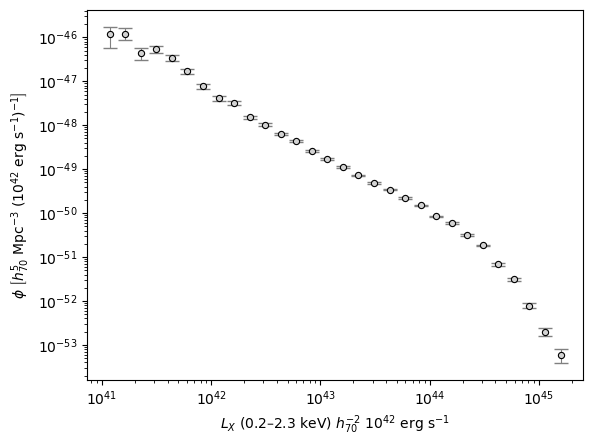

In [34]:
# Plot XLF
plt.errorbar(bin_edges[:-1], pc_phis, pc_errs, fmt='none', ecolor='gray', capsize=5, linewidth = 0.8, linestyle='None')
plt.scatter(bin_edges[:-1], pc_phis, facecolors = 'lightgrey', edgecolors = 'black', s = 20, linewidth = 0.8, zorder = 3)
plt.loglog()
plt.xlabel(r"$L_X\ (0.2$–$2.3\ \mathrm{keV})\ h_{70}^{-2}\ 10^{42}\ \mathrm{erg\ s}^{-1}$")
plt.ylabel(r"$\phi\ \left[h_{70}^{5}\ \mathrm{Mpc}^{-3}\ (10^{42}\ \mathrm{erg\ s}^{-1})^{-1}\right]$")
plt.savefig("figures/eROSITA_phi.png")
plt.show()

## The Schechter function, $\phi(L_{\text{X}},z)\mathrm{d}L_{\text{X}}$

The Schechter function is the canonical, parametric representation of the luminosity function:

$$\phi(L_{\text{X}},z)\mathrm{d}L_{\text{X}} = \phi^*\left(\frac{L_{\text{X}}}{L^*_{\text{X}}}\right)^{-\alpha} \exp\left(-\frac{L_{\text{X}}}{L^*_{\text{X}}}\right)\left(\frac{\mathrm{d}L_{\text{X}}}{L^*_{\text{X}}}\right)$$

where the parameter $\phi^*$ normalises the XLF, and $\alpha$ determines the steepness at $L_{\text{X}} < L_{\text{X}}^*$.

In [35]:
# WARPS waveband: 0.5-2.0, eROSITA waveband: 0.2-2.3, REFLEX waveband: 0.1-2.4
# Create Schechter function using parameters corresponding to the L500 waveband
phi_star = 5.0
alpha = 1.74
Lx_star = 3.02*1e44
def schechterfunction(Luminosity):
    return (phi_star * ((Luminosity/Lx_star)**-alpha) * np.exp(-Luminosity/Lx_star) * 1/Lx_star)*1e-7

Lums = np.arange(1e40, 1e45, 1e40)
eq2_phi = schechterfunction(Lums)
Lums

array([1.0000e+40, 2.0000e+40, 3.0000e+40, ..., 9.9997e+44, 9.9998e+44,
       9.9999e+44], shape=(99999,))

In [36]:
# By eye, taken a few points from the eRASS1 XLF from Figure 20 in Bulbul et al. (2024) to see if the shape is similar
bulbul_L = np.array([1e0, 1e1, 1e2, 1e3])
bulbul_phi = np.array([2e-5, 1e-6, 1e-8, 1e-11])

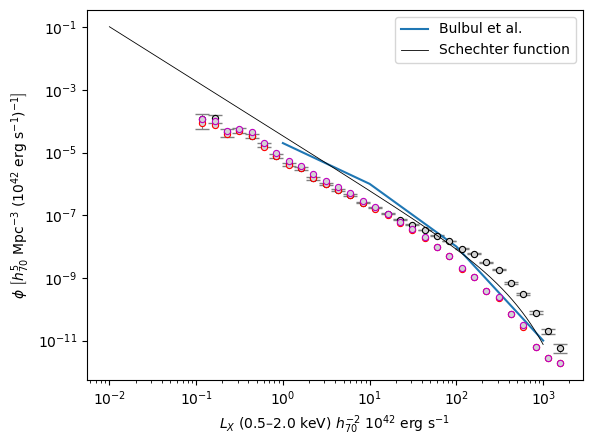

In [37]:
# Plot the Page-Carrera XLF, Schechter function, and rough Bulbul points

plt.errorbar(np.array(bin_edges[:-1])/1e42, np.array(pc_phis)*1e42, np.array(pc_errs)*1e42, fmt='none', ecolor='gray', capsize=5, linewidth = 0.8, linestyle='None')
plt.scatter(np.array(bin_edges[:-1])/1e42, np.array(pc_phis)*1e42, facecolors = 'lightgrey', edgecolors = 'black', s = 20, linewidth = 0.8, zorder = 3)

plt.scatter(np.array(bin_edges[:-1])/1e42, np.array(pc_phis_mask)*1e42, facecolors = 'lightgrey', edgecolors = 'red', s = 20, linewidth = 0.8, zorder = 3)
plt.scatter(np.array(bin_edges[:-1])/1e42, np.array(pc_phis_replace)*1e42, facecolors = 'lightgrey', edgecolors = 'm', s = 20, linewidth = 0.8, zorder = 3)

plt.plot(bulbul_L, bulbul_phi, label = 'Bulbul et al.')

plt.plot(Lums/1e42, eq2_phi*1e42, color = "black" , label = 'Schechter function', linewidth = 0.6, zorder = 3)

plt.loglog()
plt.xlabel(r"$L_X\ (0.5$–$2.0\ \mathrm{keV})\ h_{70}^{-2}\ 10^{42}\ \mathrm{erg\ s}^{-1}$")
plt.ylabel(r"$\phi\ \left[h_{70}^{5}\ \mathrm{Mpc}^{-3}\ (10^{42}\ \mathrm{erg\ s}^{-1})^{-1}\right]$")
plt.savefig("figures/eROSITA/phis_and_schechter.png")
plt.legend()
plt.show()

## Expected vs Observed numbers

The expected number of objects in the luminosity-redshift plane is obtained by integrating the XLF definition:

$$N_{\text{exp}} = \int_{L_{\text{X,min}}}^{L_{\text{X,max}}} \int_{z_{\text{min}}}^{z_{\text{max}}} \phi(L_{\text{X}},z) \Omega(f_{\text{X}},r_{\theta}) \frac{\mathrm{d}V(z)}{\mathrm{d}z} \mathrm{d}z\mathrm{d}L_{\text{X}}$$

In [38]:
# Calculate the expected number of observed clusters per luminosity bin.

N_exp = []
N_exp_errs = []
expect_deltas = []
for i, lower_bin_edge in enumerate(tqdm.tqdm(bin_edges[:-1])):
    upper_bin_edge = bin_edges[i+1]
    indecis_in_bin = np.where((lower_bin_edge <= L500_updatedmask) & (L500_updatedmask < upper_bin_edge))[0]
    clust_in_bin = len(indecis_in_bin)
    delta_L = upper_bin_edge - lower_bin_edge
    expect_deltas.append(delta_L)
    
    def Nexp_integrand(z, Luminosity):
    
        co_mo_vol_step = get_co_mo_vol_cached(z)
        DL_cm_step = get_DL_cm_cached(z)
        flux = (Luminosity / (4 * np.pi * DL_cm_step**2))
        
        flim = 6.5e-14
        if flux >= flim:
            coverage_interp = coverage_interp1d(flux)
        else:
            coverage_interp = 0
        eq1_phi = (phi_star * ((Luminosity/Lx_star)**-alpha) * np.exp(-Luminosity/Lx_star) * 1/Lx_star) *1e-7
        

        survey_area = ((coverage_interp)*tot_cov).value
        
        return (eq1_phi * survey_area * co_mo_vol_step)

        
    Nexp, Nexp_err = dblquad(Nexp_integrand, lower_bin_edge, upper_bin_edge, 0.02, 0.3, **integration_opts)
    # Nexp_poisson_err = Nexp / np.sqrt(len(indecis_in_bin))
    
    N_exp.append(Nexp)
    N_exp_errs.append(Nexp_err)

100%|██████████| 30/30 [00:18<00:00,  1.58it/s]


In [39]:
Nexp_bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
N_expected_df = pd.DataFrame({
    'bin_centre': Nexp_bin_centres,
    'bin_edge_lower': bin_edges[:-1],
    'bin_edge_upper': bin_edges[1:],
    'N_exp': N_exp,
    'delta_L': expect_deltas
})
N_expected_df.to_csv('eROSITA_expected_observations.csv', index=False) 

In [40]:
binned_counts, _ = np.histogram(L500_updatedmask, bins=bin_edges)
binned_counts

array([  4,   9,  11,  31,  60,  61,  66,  79, 121, 144, 192, 257, 347,
       385, 484, 569, 586, 613, 558, 432, 352, 207, 163,  81,  70,  29,
        18,   5,   3,   3])

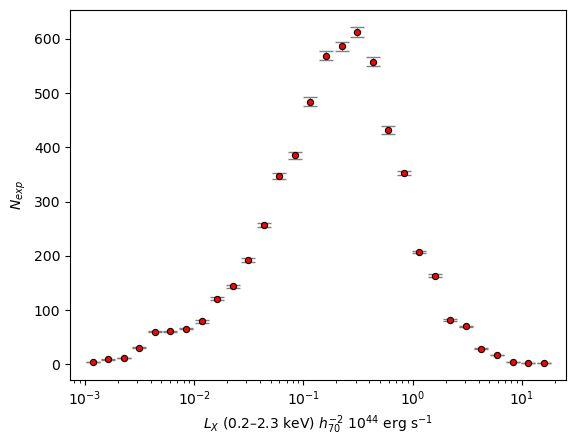

In [41]:
# Plot the N_exp values
plt.errorbar(bin_edges[:-1]/1e44, binned_counts, yerr = np.array(N_exp_errs), fmt='none', ecolor='gray', capsize=5, linewidth = 0.8, linestyle='None')
plt.scatter(bin_edges[:-1]/1e44, binned_counts, facecolors = 'red', edgecolors = 'black', s = 20, linewidth = 0.8, zorder = 3)

plt.xlabel(r"$L_X\ (0.2$–$2.3\ \mathrm{keV})\ h_{70}^{-2}\ 10^{44}\ \mathrm{erg\ s}^{-1}$")
plt.ylabel(r'$N_{exp}$')
# plt.xlim(1e-2, 1e1)
# plt.ylim(0, 20)
plt.xscale("log")
plt.savefig("figures/eROSITA/nexpnexp.png")
plt.show()

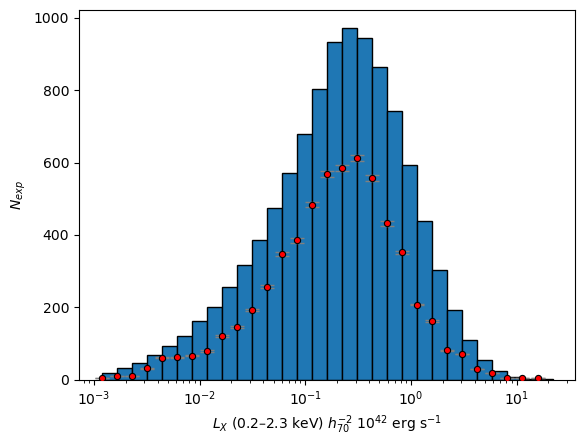

In [42]:
# Plot N_exp alongside N_obs (observed number of clusters per bin)
plt.bar(Nexp_bin_centres/1e44, np.array(N_exp), width=np.diff(bin_edges/1e44), align='center', edgecolor='black')

plt.errorbar(bin_edges[:-1]/1e44, binned_counts, yerr = np.array(N_exp_errs), fmt='none', ecolor='gray', capsize=5, linewidth = 0.8, linestyle='None')
plt.scatter(bin_edges[:-1]/1e44, binned_counts, facecolors = 'red', edgecolors = 'black', s = 20, linewidth = 0.8, zorder = 3)

plt.xlabel(r"$L_X\ (0.2$–$2.3\ \mathrm{keV})\ h_{70}^{-2}\ 10^{42}\ \mathrm{erg\ s}^{-1}$")
plt.ylabel(r'$N_{exp}$')
# plt.xlim(1e-2, 1e1)
# plt.ylim(0, 20)
plt.xscale("log")
plt.savefig("figures/eROSITA/histogram.png")
plt.show()

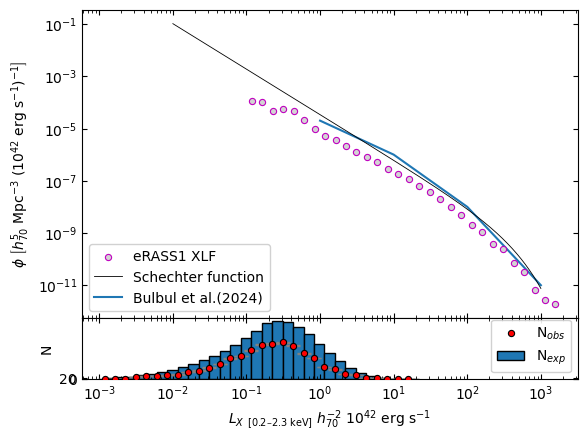

In [60]:
# Condense both the XLF plot and the N_exp/N_obs to be together 

# Edit height ratios to change the split in image size between the two
fig, [ax2, ax1] = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [5, 1]})

# Upper (main) axes showing XLF

# ax2.errorbar(bin_centres, phi, yerr=phi_err, fmt='r.', zorder=2, label="eRASS:1 Page&Carrera method ") 
ax2.scatter(np.array(bin_edges[:-1])/1e42, np.array(pc_phis_replace)*1e42, label = "eRASS1 XLF",facecolors = 'lightgrey', edgecolors = 'm', s = 20, linewidth = 0.8, zorder = 3)
ax2.plot(Lums/1e42, eq2_phi*1e42, color = "black" , label = 'Schechter function', linewidth = 0.6, zorder = 3)
ax2.plot(bulbul_L, bulbul_phi, label = 'Bulbul et al.(2024)')

#Lower axis showing N_obs
ax1.errorbar(bin_edges[:-1]/1e44, binned_counts, yerr = np.array(N_exp_errs), fmt='none', ecolor='gray', capsize=5, linewidth = 0.8, linestyle='None')
ax1.scatter(bin_edges[:-1]/1e44, binned_counts, label = r"N$_{obs}$", facecolors = 'red', edgecolors = 'black', s = 20, linewidth = 0.8, zorder = 3)

ax1.bar(Nexp_bin_centres/1e44, np.array(N_exp), width=np.diff(bin_edges/1e44), label = r"N$_{exp}$", align='center', edgecolor='black')

# Change the plot settings as needed, e.g.

ax2.set_yscale('log')
ax2.set_xscale('log')

ax1.set_xscale('log')

 
# Plot
plt.xlabel(r"$L_X\ _{[0.2–2.3\ \mathrm{keV}]}\ h_{70}^{-2}\ 10^{42}\ \mathrm{erg\ s}^{-1}$")

ax2.set_ylabel(r"$\phi\ \left[h_{70}^{5}\ \mathrm{Mpc}^{-3}\ (10^{42}\ \mathrm{erg\ s}^{-1})^{-1}\right]$")

ax1.set_ylabel('N')

ax1.tick_params(which='both', direction="in", right=True, top=True)

ax2.tick_params(which='both', direction="in", right=True, top=True)

ax1.legend(loc = 'lower right', framealpha=0.9)

ax2.legend(loc='lower left', framealpha=0.9)

ax1.set_yticks(range(0,21,10), labels=['0','','20'])

plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('figures/eROSITA/XLF_N.png')

## WARPS and eRASS:1 Luminosities comparison
This was to attempt and convert the selection function into the correct energy band but it didn't work, left it in for completion anyhow.

In [44]:
# Importing the WARPS luminosities from Koens et al. (2013)
Lx_z = pd.read_csv('data/koens_2013/warps_xlf.dat', delim_whitespace=True, header=0)
print(Lx_z.head())

         Lx      z     Lxerr
0  0.031099  0.029  0.001703
1  0.014380  0.045  0.001669
2  0.009963  0.051  0.000585
3  0.043801  0.080  0.002972
4  0.015892  0.081  0.001483


C:\Users\LilyO\AppData\Local\Temp\ipykernel_16140\751916800.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  Lx_z = pd.read_csv('data/koens_2013/warps_xlf.dat', delim_whitespace=True, header=0)


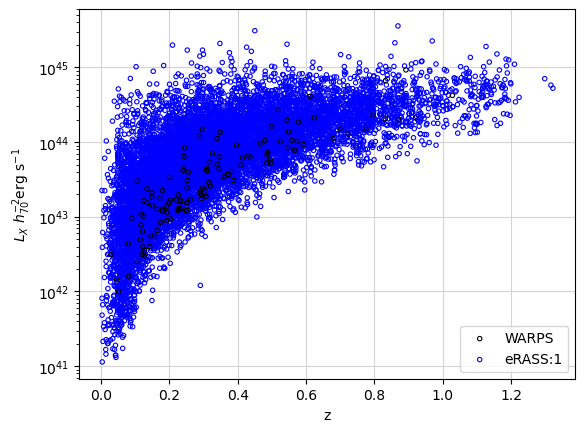

In [45]:
plt.scatter(Lx_z["z"], Lx_z["Lx"]*1e44, facecolors = 'none', edgecolors = 'black', label = 'WARPS', s = 10,  linewidth = 0.8, zorder = 4)
plt.scatter(z, L500*1e42, facecolors = 'none', edgecolors = 'blue', label = 'eRASS:1', s = 10, linewidth = 0.8, zorder = 3)
plt.yscale("log")
plt.xlabel("z")
plt.ylabel(r"$L_X\ h_{70}^{-2} \mathrm{erg\ s}^{-1}$")
plt.grid(True, color = 'lightgrey', zorder = 0)
# plt.xlim(0, 1.1)
# plt.ylim(1e41, 1e46)
plt.legend()
plt.savefig("figures/WARPS_and_eRASS_L.png")
plt.show()

## eRASS:1 energy bands conversion

In [46]:
comparing = pd.read_csv('L_0p3to2p3_0p5to2p0.csv')
comparing

,L500,L500_0520
0,17.564,12.064
1,1.095,0.829
2,0.217,0.160
3,0.349,0.259
4,0.203,0.111
...,...,...
5255,30.008,20.786
5256,260.882,179.304
5257,112.285,78.238
5258,1498.455,1043.619


In [47]:
eRASS1 = comparing['L500']*1e42
WARPS = comparing['L500_0520']*1e42

In [48]:
eRASS1 = np.sort(eRASS1)
WARPS = np.sort(WARPS)
len(eRASS1), len(WARPS)
# len(eRASS1[:20]/WARPS[:20])
# len(eRASS1[5240:5260]/WARPS[5240:5260])

(5260, 5260)

In [49]:
sum((eRASS1[:20]/WARPS[:20]))/20

np.float64(1.4922080382549319)

In [50]:
sum((eRASS1[5240:5260]/WARPS[5240:5260]))/20

np.float64(1.443766430717206)

In [51]:
eRASS1[0], WARPS[0]

(np.float64(1.3100000000000002e+41), np.float64(9.2e+40))

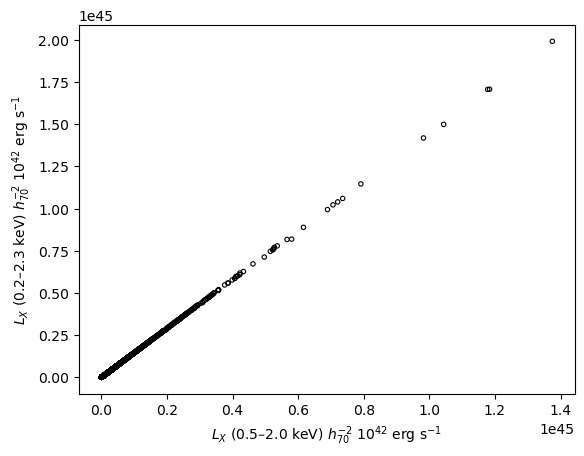

In [52]:
plt.scatter(WARPS, eRASS1, facecolors = 'none', edgecolors = 'black', s = 10, linewidth = 0.8, zorder = 3)
plt.xlabel(r"$L_X\ (0.5$–$2.0\ \mathrm{keV})\ h_{70}^{-2}\ 10^{42}\  \mathrm{erg\ s}^{-1}$")
plt.ylabel(r"$L_X\ (0.2$–$2.3\ \mathrm{keV})\ h_{70}^{-2}\ 10^{42}\ \mathrm{erg\ s}^{-1}$")
# plt.loglog()
plt.savefig('figures/eRASS1_vs_WARPS.png')

In [53]:
selectfunc_limits = [10**(40.9), 10**(45.6)]
lum_interp1 = np.interp(10**(40.9), WARPS, eRASS1)
lum_interp2 = np.interp(10**(45.6), WARPS, eRASS1)

# selectfunc_limits = [40.9, 45.6]
# lum_interp = np.interp(selectfunc_limits, WARPS, eRASS1)

In [54]:
# lum_interp1, lum_interp2
lum_interp1, lum_interp2

(np.float64(1.3100000000000002e+41), np.float64(1.990426e+45))

In [55]:
lower = (10**40.8)*1.49
higher = (10**45.6)*1.44

In [56]:
np.log10(lower), np.log10(higher)

(np.float64(40.97318626841227), np.float64(45.75836249209525))